This project aims to predict the next trading day’s market direction using ticker-specific data (e.g., volume, trading prices, moving averages) alongside broader market sentiment from the S&P 500 (GSPC) and industry trends from SPDR S&P Retail ETF (XRT) and iShares U.S. Consumer Staples ETF (IYK).

Classes Taken - Supervised ML

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import random



# Exploratory Analysis

In [2]:
#download 10 years of Costco Data
costco_data = yf.download('COST', start ='2004-01-01', end = '2024-12-31')
costco_data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,COST,COST,COST,COST,COST
Date,,,,,
2004-01-02,24.364307,25.102212,24.270393,24.947923,2603100
2004-01-05,24.250273,24.558851,24.055733,24.444810,3968300
2004-01-06,24.525312,24.773516,24.189901,24.216732,3124300
2004-01-07,24.874140,24.941221,24.498478,24.538728,3467100
2004-01-08,24.994898,25.176021,24.833902,25.088815,4973100


In [3]:
costco_dataset = pd.DataFrame(costco_data)
costco_dataset.head()

Price,Close,High,Low,Open,Volume
Ticker,COST,COST,COST,COST,COST
Date,,,,,
2004-01-02,24.364307,25.102212,24.270393,24.947923,2603100
2004-01-05,24.250273,24.558851,24.055733,24.444810,3968300
2004-01-06,24.525312,24.773516,24.189901,24.216732,3124300
2004-01-07,24.874140,24.941221,24.498478,24.538728,3467100
2004-01-08,24.994898,25.176021,24.833902,25.088815,4973100


In [4]:
costco_dataset.isnull().sum()

,,0
Price,Ticker,
Close,COST,0
High,COST,0
Low,COST,0
Open,COST,0
Volume,COST,0


In [5]:
costco_dataset.describe()

Price,Close,High,Low,Open,Volume
Ticker,COST,COST,COST,COST,COST
count,5284.000000,5284.000000,5284.000000,5284.000000,5.284000e+03
mean,187.400510,188.921245,185.690681,187.303301,2.938809e+06
std,206.742041,208.422461,204.820167,206.666193,1.934513e+06
min,23.904972,24.059675,23.575386,23.911690,1.033000e+05
25%,42.335133,42.714607,42.010896,42.301261,1.767900e+06
50%,95.822323,96.197691,95.080532,95.717988,2.371750e+06
75%,266.444489,268.894567,262.594872,265.360773,3.531300e+06
max,993.592163,1007.137200,992.493402,1000.574443,4.032770e+07


In [6]:
costco_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5284 entries, 2004-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, COST)   5284 non-null   float64
 1   (High, COST)    5284 non-null   float64
 2   (Low, COST)     5284 non-null   float64
 3   (Open, COST)    5284 non-null   float64
 4   (Volume, COST)  5284 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 247.7 KB


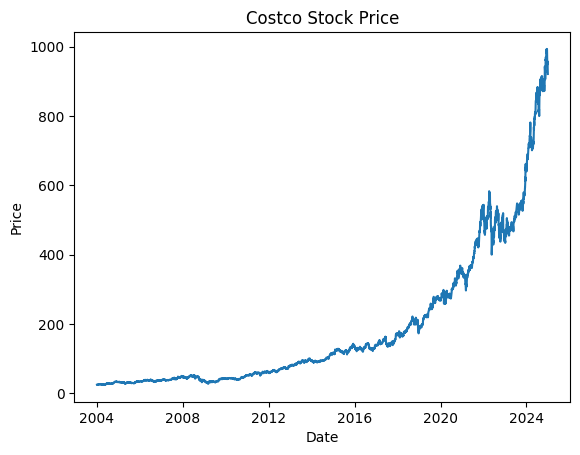

In [7]:
plt.plot(costco_dataset["Close"])
plt.title("Costco Stock Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

Percentage Change from Close Day by Day <br>
It reflects how much the price fluctuates day by day. Larger percentage changes indicate higher volatility, while smaller changes suggest a more stable price. Sudden and significant percentage changes often reflect shifts in investor sentiment or reaction to external events. High daily percentage changes might highlight riskier investments, as the asset experiences significant price swings. Low changes might indicate a more stable, lower-risk asset. Enables comparison of performance across different assets or indices on a normalized scale.

In [8]:
costco_percent_chg = costco_dataset.copy()
costco_percent_chg['Percentage Change'] = (costco_percent_chg['Close'] - costco_percent_chg['Close'].shift(1)) / costco_percent_chg['Close'].shift(1)
costco_percent_chg.head()

Price,Close,High,Low,Open,Volume,Percentage Change
Ticker,COST,COST,COST,COST,COST,
Date,,,,,,
2004-01-02,24.364307,25.102212,24.270393,24.947923,2603100,NaN
2004-01-05,24.250273,24.558851,24.055733,24.444810,3968300,-0.004680
2004-01-06,24.525312,24.773516,24.189901,24.216732,3124300,0.011342
2004-01-07,24.874140,24.941221,24.498478,24.538728,3467100,0.014223
2004-01-08,24.994898,25.176021,24.833902,25.088815,4973100,0.004855


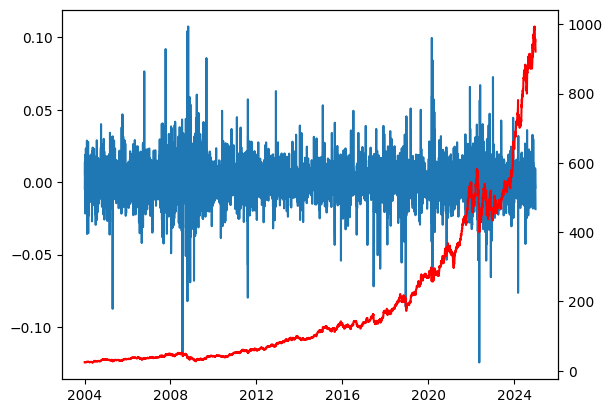

In [9]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(costco_percent_chg["Percentage Change"])
ax2.plot(costco_percent_chg["Close"], color = 'red')
plt.show()

# Moving Average

This is a lagged indicator, they are backwards looking. By smoothing out short-term fluctuations, the moving average provides a clearer view of the underlying trend, reducing the impact of day-to-day price volatility. The slope of the moving average indicates the strength of the trend: A steep slope signals strong momentum. A gentle slope suggests weaker momentum. <br> <br>


In [10]:
costco_moving_avg = costco_dataset.copy()

## Moving Average : For Loop and Iterations

In [11]:
#for loop and iterations
%%timeit
def moving_avg(input, window_size):
  result=[]
  moving_sum = sum(input[:window_size])
  result.append(moving_sum/window_size)
  for i in range(len(input)- window_size):
    moving_sum += input[i + window_size] - input[i]
    result.append(moving_sum/window_size)
  return result

input = costco_moving_avg['Close'].values
window_size = 155
moving_avg_data = moving_avg(input, window_size)


#add a column for the moving avg but only starting at the 15th index
costco_moving_avg['Moving Avg Loop'] = [None] * (window_size - 1) + moving_avg_data


54.6 ms ± 5.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
costco_moving_avg.head(158)

Price,Close,High,Low,Open,Volume,Moving Avg Loop
Ticker,COST,COST,COST,COST,COST,
Date,,,,,,
2004-01-02,24.364307,25.102212,24.270393,24.947923,2603100,None
2004-01-05,24.250273,24.558851,24.055733,24.444810,3968300,None
2004-01-06,24.525312,24.773516,24.189901,24.216732,3124300,None
2004-01-07,24.874140,24.941221,24.498478,24.538728,3467100,None
2004-01-08,24.994898,25.176021,24.833902,25.088815,4973100,None
...,...,...,...,...,...,...
2004-08-12,27.300997,27.678584,27.145914,27.516761,3812800,None
2004-08-13,27.462818,27.698812,27.300996,27.314479,2318100,[25.928667486867596]


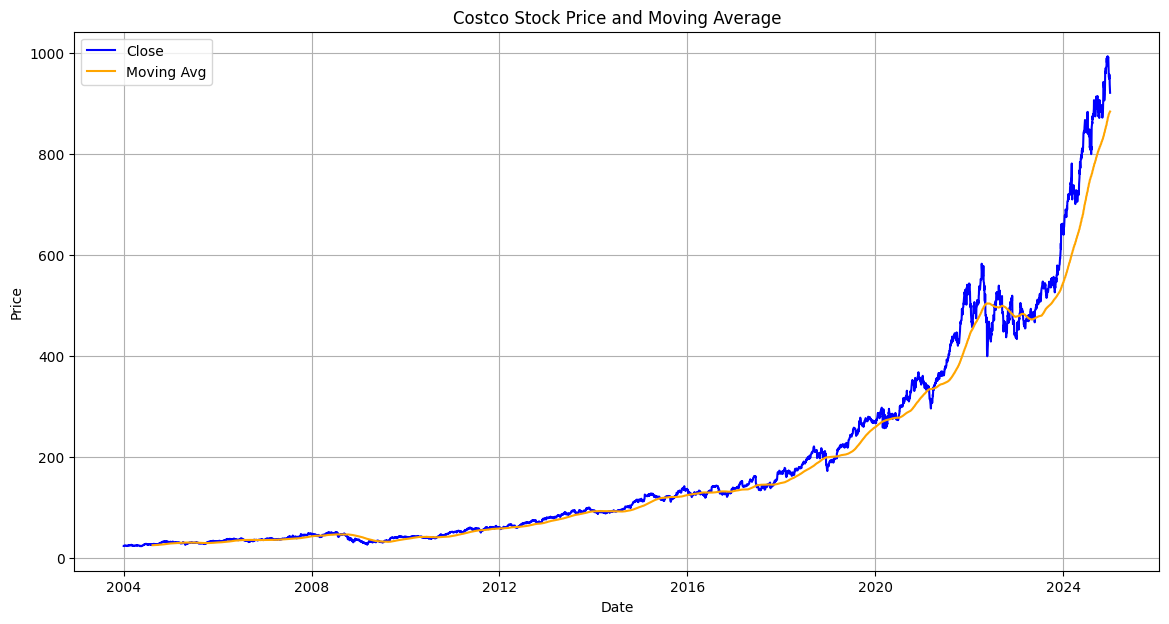

In [13]:
plt.figure(figsize=(14, 7))
plt.plot(costco_moving_avg.index, costco_moving_avg['Close'], label='Close', color='blue')
plt.plot(costco_moving_avg.index, costco_moving_avg['Moving Avg Loop'], label='Moving Avg', color='orange')
plt.title('Costco Stock Price and Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

## Moving Average : Rolling ()

In [14]:
%%timeit
window_size = 155
costco_moving_avg['Moving Avg Rolling'] = costco_moving_avg['Close'].rolling(window=window_size).mean()

2.46 ms ± 241 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
costco_moving_avg.head(15)

Price,Close,High,Low,Open,Volume,Moving Avg Loop,Moving Avg Rolling
Ticker,COST,COST,COST,COST,COST,,
Date,,,,,,,
2004-01-02,24.364307,25.102212,24.270393,24.947923,2603100,None,NaN
2004-01-05,24.250273,24.558851,24.055733,24.444810,3968300,None,NaN
2004-01-06,24.525312,24.773516,24.189901,24.216732,3124300,None,NaN
2004-01-07,24.874140,24.941221,24.498478,24.538728,3467100,None,NaN
2004-01-08,24.994898,25.176021,24.833902,25.088815,4973100,None,NaN
2004-01-09,25.464468,25.732799,24.807061,25.035141,6193300,None,NaN
2004-01-12,25.290047,25.397378,24.921094,25.357128,3195400,None,NaN
2004-01-13,25.397373,25.477871,25.129043,25.176000,2092200,None,NaN


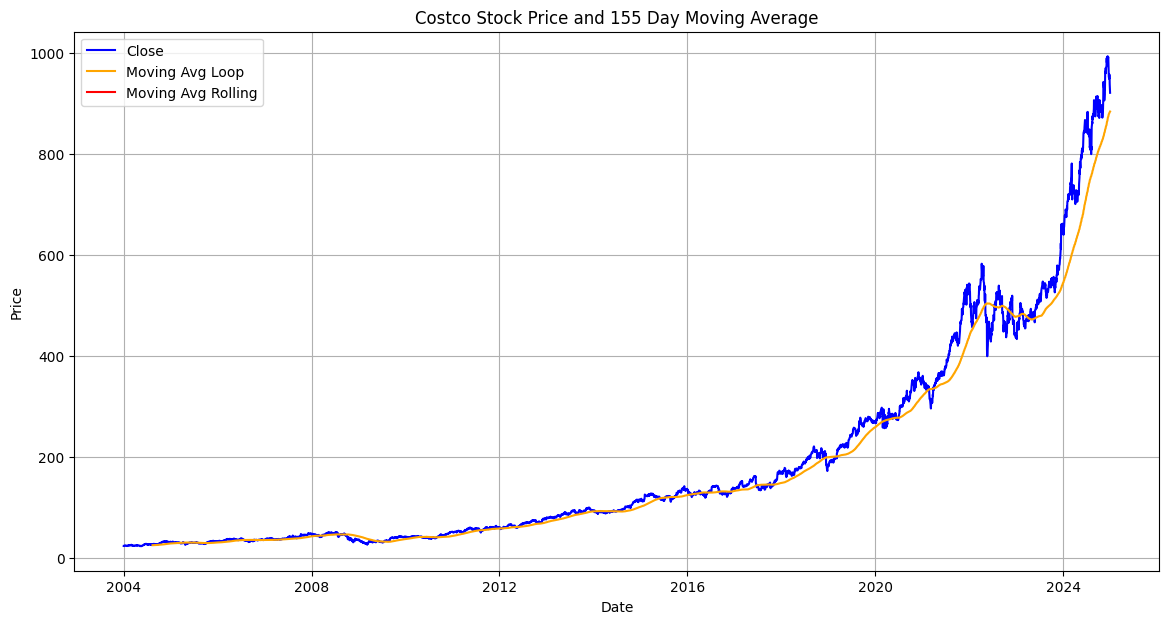

In [16]:
window_size = 155
plt.figure(figsize=(14, 7))
plt.plot(costco_moving_avg.index, costco_moving_avg['Close'], label='Close', color='blue')
plt.plot(costco_moving_avg.index, costco_moving_avg['Moving Avg Loop'], label='Moving Avg Loop', color='orange')
plt.plot(costco_moving_avg.index, costco_moving_avg['Moving Avg Rolling'], label='Moving Avg Rolling', color='red')
plt.title(f'Costco Stock Price and {window_size} Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [17]:
#validate that both codes have the same output
costco_moving_avg['For Loop and Rolling are the same'] = costco_moving_avg['Moving Avg Loop'] == costco_moving_avg['Moving Avg Rolling']
not_same = costco_moving_avg[(costco_moving_avg['Moving Avg Loop'] == False) & (costco_moving_avg['Moving Avg Loop'].notnull())]
print(not_same)

Empty DataFrame
Columns: [(Close, COST), (High, COST), (Low, COST), (Open, COST), (Volume, COST), (Moving Avg Loop, ), (Moving Avg Rolling, ), (For Loop and Rolling are the same, )]
Index: []


Both methods lead us to the same moving average amount as seen by the empty DataFrame.

## Moving Average : Iteration with 2 - a 50 and a 100 day

Next Steps:  <br> <br>
Crossovers (Trading Signals)

Moving averages can generate buy or sell signals when used with multiple time periods: <br>
Golden Cross: A short-term MA (e.g., 50-day) crosses above a long-term MA (e.g., 200-day), signaling a bullish trend. <br>
Death Cross: A short-term MA crosses below a long-term MA, signaling a bearish trend.

## Moving Average : Conclusion

Preferred method for doing moving averages would be the pandas rolling(). This is because it is much faster, less computationally heavy, simpler to write, and easier to read compared to the loop/iterations method. The loop/iterations method help clarify what it is that is done with the panda's rolling() code.

# Model

## Creating the dataset

In [18]:
costco_dataset_rf = costco_dataset.copy()

Columns added based off of Costco data: <br>
- **Tomorrow's Close** = Tomorrow's Close <br>
- **Outcome** = 1 - stock increased , 0 - stock decreased
- **Close Ratio** = today's close / previous x day's average
- **Trend** = for the previous x days, how many days the stock went up the next day (uses Outcome)

In [19]:
#Add "COST"-for costco- to create a multi-index (the data will only apply to the tomorrow's open)
costco_dataset_rf["Tomorrow's Open", "COST"] = costco_dataset_rf["Open"].shift(-1)
costco_dataset_rf.dropna(inplace=True)
costco_dataset_rf.info()
#convert true/false into numerical since rf classifier operates numerically
costco_dataset_rf["Tmr_Open_Outcome"] = (costco_dataset_rf["Tomorrow's Open"] > costco_dataset_rf["Close"]).astype(int)
costco_dataset_rf.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5283 entries, 2004-01-02 to 2024-12-27
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   (Close, COST)            5283 non-null   float64
 1   (High, COST)             5283 non-null   float64
 2   (Low, COST)              5283 non-null   float64
 3   (Open, COST)             5283 non-null   float64
 4   (Volume, COST)           5283 non-null   int64  
 5   (Tomorrow's Open, COST)  5283 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 288.9 KB


Price,Close,High,Low,Open,Volume,Tomorrow's Open,Tmr_Open_Outcome
Ticker,COST,COST,COST,COST,COST,COST,
Date,,,,,,,
2004-01-02,24.364307,25.102212,24.270393,24.947923,2603100,24.444810,1
2004-01-05,24.250273,24.558851,24.055733,24.444810,3968300,24.216732,0
2004-01-06,24.525312,24.773516,24.189901,24.216732,3124300,24.538728,1
2004-01-07,24.874140,24.941221,24.498478,24.538728,3467100,25.088815,1
2004-01-08,24.994898,25.176021,24.833902,25.088815,4973100,25.035141,1


In [20]:
#No Information Rate - NIR - The NIR is the accuracy you would achieve by always predicting the majority class in your data.
#It's often used as a baseline to assess whether your classification model provides meaningful insights.

class_counts = costco_dataset_rf['Tmr_Open_Outcome'].value_counts()

# Calculate the NIR
nir = class_counts.max() / len(costco_dataset_rf)
print("No Information Rate:", nir)


No Information Rate: 0.5354911981828506


In [21]:
#time periods of 2 days, a week, quarter, semi-yearly, yearly, 2 years
horizons = [2, 5, 63, 125, 250, 500]
new_predictors = []

for horizon in horizons:
  rolling_averages = costco_dataset_rf.rolling(horizon).mean()

  ratio_column=f"Open Ratio {horizon}"
  costco_dataset_rf[ratio_column] = costco_dataset_rf["Open"] / rolling_averages["Open"]
  #a sum of how many days the stock went up
  trend_column = f"Trend {horizon}"
  costco_dataset_rf[trend_column] = costco_dataset_rf.shift(1).rolling(horizon).sum()["Tmr_Open_Outcome"]

  new_predictors += [ratio_column, trend_column]

Why am I looking at the Open Ratio : <br>
For predicting the next opening price relative to the current closing price, the rolling average of the opening prices would likely be more relevant because it reflects the pattern of the opening prices themselves, which will inform your prediction of the upcoming opening price.

In [22]:
costco_dataset_rf = costco_dataset_rf.dropna()
costco_dataset_rf.head()

Price,Close,High,Low,Open,Volume,Tomorrow's Open,Tmr_Open_Outcome,Open Ratio 2,Trend 2,Open Ratio 5,Trend 5,Open Ratio 63,Trend 63,Open Ratio 125,Trend 125,Open Ratio 250,Trend 250,Open Ratio 500,Trend 500
Ticker,COST,COST,COST,COST,COST,COST,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,
2005-12-27,33.957741,34.380762,33.916802,34.210189,1315400,34.025984,1,1.001598,2.0,1.010561,4.0,1.048725,32.0,1.091748,59.0,1.102774,132.0,1.165551,241.0
2005-12-28,34.189735,34.380777,33.923641,34.025984,1306200,34.087372,0,0.997300,2.0,0.999880,5.0,1.040780,32.0,1.084932,60.0,1.096641,133.0,1.158518,241.0
2005-12-29,34.094196,34.285238,34.032790,34.087372,1147400,33.978200,0,1.000901,1.0,0.999800,4.0,1.040005,32.0,1.085929,59.0,1.098408,133.0,1.159829,241.0
2005-12-30,33.753044,34.387577,33.698459,33.978200,1380800,33.944085,1,0.998396,0.0,0.996997,3.0,1.034245,31.0,1.081534,58.0,1.094690,132.0,1.155372,240.0
2006-01-03,34.060074,34.148773,33.254970,33.944085,2583100,33.985035,0,0.999498,1.0,0.996914,3.0,1.030892,32.0,1.079572,59.0,1.093300,132.0,1.153517,240.0


Columns added based on industry trends and prices:
- **S&P 500 [GSPC]** : Overall market sentiment, market wide influences.
- **SPDR S&P Retail ETF [XRT]** : Industry Focus - Retail.  Focusing on department stores and specialty retailers. Key Holdings: Amazon, Home Depot, Walmart, Lowe's. Low Costco holdings.
- **iShares U.S. Consumer Staples ETF [IYK]** : Industry - Consumer Defensive. No Costco holdings.

<br>


Chosen because Costco is not a top holding for the ETF <br>
XLP  -  had too high a percentage of Costco <br>
RETL - had too high a percentage of Costco


In [23]:
sp500_data = yf.download('^GSPC', start ='2004-01-01', end = '2024-12-31')
sp500_data = sp500_data[["Open","Volume"]]

XRT_data = yf.download('XRT', start ='2004-01-01', end = '2024-12-31')
XRT_data = XRT_data[["Open","Volume"]]

IYK_data = yf.download('IYK', start ='2004-01-01', end = '2024-12-31')
IYK_data = IYK_data[["Open","Volume"]]



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [24]:
for i in [sp500_data, XRT_data, IYK_data]:
  costco_dataset_rf = costco_dataset_rf.join(i)

costco_dataset_rf.head(5)


Price,Close,High,Low,Open,Volume,Tomorrow's Open,Tmr_Open_Outcome,Open Ratio 2,Trend 2,Open Ratio 5,...,Open Ratio 250,Trend 250,Open Ratio 500,Trend 500,Open,Volume,Open,Volume,Open,Volume
Ticker,COST,COST,COST,COST,COST,COST,,,,,...,,,,,^GSPC,^GSPC,XRT,XRT,IYK,IYK
Date,,,,,,,,,,,,,,,,,,,,,
2005-12-27,33.957741,34.380762,33.916802,34.210189,1315400,34.025984,1,1.001598,2.0,1.010561,...,1.102774,132.0,1.165551,241.0,1268.660034,1540470000,NaN,NaN,11.838275,223500
2005-12-28,34.189735,34.380777,33.923641,34.025984,1306200,34.087372,0,0.997300,2.0,0.999880,...,1.096641,133.0,1.158518,241.0,1256.540039,1422360000,NaN,NaN,11.759273,69600
2005-12-29,34.094196,34.285238,34.032790,34.087372,1147400,33.978200,0,1.000901,1.0,0.999800,...,1.098408,133.0,1.159829,241.0,1258.170044,1382540000,NaN,NaN,11.763661,155100
2005-12-30,33.753044,34.387577,33.698459,33.978200,1380800,33.944085,1,0.998396,0.0,0.996997,...,1.094690,132.0,1.155372,240.0,1254.420044,1443500000,NaN,NaN,11.746097,185400
2006-01-03,34.060074,34.148773,33.254970,33.944085,2583100,33.985035,0,0.999498,1.0,0.996914,...,1.093300,132.0,1.153517,240.0,1248.290039,2554570000,NaN,NaN,11.697815,1570200


In [25]:
costco_dataset_rf = costco_dataset_rf.dropna()
costco_dataset_rf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4661 entries, 2006-06-22 to 2024-12-27
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   (Close, COST)            4661 non-null   float64
 1   (High, COST)             4661 non-null   float64
 2   (Low, COST)              4661 non-null   float64
 3   (Open, COST)             4661 non-null   float64
 4   (Volume, COST)           4661 non-null   int64  
 5   (Tomorrow's Open, COST)  4661 non-null   float64
 6   (Tmr_Open_Outcome, )     4661 non-null   int64  
 7   (Open Ratio 2, )         4661 non-null   float64
 8   (Trend 2, )              4661 non-null   float64
 9   (Open Ratio 5, )         4661 non-null   float64
 10  (Trend 5, )              4661 non-null   float64
 11  (Open Ratio 63, )        4661 non-null   float64
 12  (Trend 63, )             4661 non-null   float64
 13  (Open Ratio 125, )       4661 non-null   float64
 14  (Trend

In [26]:
#We have to make the multidemensional dataframe flat before working with pandas
# Assuming 'df' is your DataFrame with a multi-level column
costco_dataset_rf.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in costco_dataset_rf.columns]

# Now the column names should be flattened into one dimension
print(costco_dataset_rf.head())


            Close_COST  High_COST   Low_COST  Open_COST  Volume_COST  \
Date                                                                   
2006-06-22   37.885426  38.166464  37.686641  38.049935      2687800   
2006-06-23   38.043087  38.481782  37.768902  37.768902      1879200   
2006-06-26   38.591461  38.646299  37.967692  38.001964      2763300   
2006-06-27   38.145916  38.906776  37.995114  38.468081      2979300   
2006-06-28   38.426945  38.557181  38.043086  38.207597      1870000   

            Tomorrow's Open_COST  Tmr_Open_Outcome_  Open Ratio 2_  Trend 2_  \
Date                                                                           
2006-06-22             37.768902                  0       1.007167       0.0   
2006-06-23             38.001964                  0       0.996293       0.0   
2006-06-26             38.468081                  0       1.003076       0.0   
2006-06-27             38.207597                  1       1.006095       0.0   
2006-06-28     

In [27]:
costco_dataset_rf['Tmr_Open_Outcome_'] = costco_dataset_rf['Tmr_Open_Outcome_'].astype('category')

# To check the changes
print(costco_dataset_rf.dtypes)


Close_COST               float64
High_COST                float64
Low_COST                 float64
Open_COST                float64
Volume_COST                int64
Tomorrow's Open_COST     float64
Tmr_Open_Outcome_       category
Open Ratio 2_            float64
Trend 2_                 float64
Open Ratio 5_            float64
Trend 5_                 float64
Open Ratio 63_           float64
Trend 63_                float64
Open Ratio 125_          float64
Trend 125_               float64
Open Ratio 250_          float64
Trend 250_               float64
Open Ratio 500_          float64
Trend 500_               float64
Open_^GSPC               float64
Volume_^GSPC               int64
Open_XRT                 float64
Volume_XRT               float64
Open_IYK                 float64
Volume_IYK                 int64
dtype: object


In [28]:
from sklearn.model_selection import train_test_split

predictors = [("Close_COST"),("Open_COST"),("High_COST"),
  ("Low_COST"), ("Volume_COST"),
  ("Open Ratio 2_"), ("Trend 2_"),
  ("Open Ratio 5_"), ("Trend 5_"),
  ("Open Ratio 63_"), ("Trend 63_"),
  ("Open Ratio 125_"), ("Trend 125_"),
  ("Open Ratio 250_"), ("Trend 250_"),
  ("Open Ratio 500_"), ("Trend 500_"),
  ("Open_^GSPC"), ("Volume_^GSPC"),
  ("Open_XRT"), ("Volume_XRT"),
  ("Open_IYK"), ("Volume_IYK")
]

X = costco_dataset_rf[predictors]
y = costco_dataset_rf["Tmr_Open_Outcome_"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [29]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_train.dtypes)
print(y_train.dtypes)
print(X_test.dtypes)
print(y_test.dtypes)

(3728, 23)
(3728,)
(933, 23)
(933,)
Close_COST         float64
Open_COST          float64
High_COST          float64
Low_COST           float64
Volume_COST          int64
Open Ratio 2_      float64
Trend 2_           float64
Open Ratio 5_      float64
Trend 5_           float64
Open Ratio 63_     float64
Trend 63_          float64
Open Ratio 125_    float64
Trend 125_         float64
Open Ratio 250_    float64
Trend 250_         float64
Open Ratio 500_    float64
Trend 500_         float64
Open_^GSPC         float64
Volume_^GSPC         int64
Open_XRT           float64
Volume_XRT         float64
Open_IYK           float64
Volume_IYK           int64
dtype: object
category
Close_COST         float64
Open_COST          float64
High_COST          float64
Low_COST           float64
Volume_COST          int64
Open Ratio 2_      float64
Trend 2_           float64
Open Ratio 5_      float64
Trend 5_           float64
Open Ratio 63_     float64
Trend 63_          float64
Open Ratio 125_    floa

# Create Preprocessing Pipeline

In [30]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn import set_config

set_config(display='diagram') # shows the pipeline graphically when printed

num_pipeline = Pipeline([
        ('scaler', StandardScaler())
    ])

prep_pipeline = ColumnTransformer([
    ('num', num_pipeline, make_column_selector(dtype_include=np.number)) ##apply this to all columns where the dtype is number/object for the next one.
])

prep_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fb03ac2e7d0>)])

# Preliminary Evaluation : Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

log_reg = make_pipeline(prep_pipeline,LogisticRegression())
log_reg.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb03ac2e7d0>)])),
                ('logisticregression', LogisticRegression())])

In [32]:
from sklearn.metrics import balanced_accuracy_score

# Predict on both training and test datasets
log_reg_y_train_pred = log_reg.predict(X_train)
log_reg_y_test_pred = log_reg.predict(X_test)

# Calculate the balanced accuracy scores
log_reg_balanced_accuracy_train = balanced_accuracy_score(y_train, log_reg_y_train_pred)
log_reg_balanced_accuracy_test = balanced_accuracy_score(y_test, log_reg_y_test_pred)

# Print the results
print(f"Logistic Regression : Balanced Accuracy Score (Train): {log_reg_balanced_accuracy_train:.4f}")
print(f"Logistic Regression : Balanced Accuracy Score (Test): {log_reg_balanced_accuracy_test:.4f}")

Logistic Regression : Balanced Accuracy Score (Train): 0.5274
Logistic Regression : Balanced Accuracy Score (Test): 0.5074


In [33]:
from sklearn.metrics import classification_report

# Generate the classification report
training_log_reg_report = classification_report(y_train, log_reg_y_train_pred)
print("Logistic Regression : Training Set Classification Report :")
print(training_log_reg_report)

test_log_reg_report = classification_report(y_test, log_reg_y_test_pred)
print("Logistic Regression : Test Set Classification Report :")
print(test_log_reg_report)

Logistic Regression : Training Set Classification Report :
              precision    recall  f1-score   support

           0       0.54      0.19      0.28      1689
           1       0.56      0.87      0.68      2039

    accuracy                           0.56      3728
   macro avg       0.55      0.53      0.48      3728
weighted avg       0.55      0.56      0.50      3728

Logistic Regression : Test Set Classification Report :
              precision    recall  f1-score   support

           0       0.50      0.17      0.25       442
           1       0.53      0.85      0.65       491

    accuracy                           0.53       933
   macro avg       0.51      0.51      0.45       933
weighted avg       0.51      0.53      0.46       933



# Feature Selection

## SelectKBest - RandomizedSearchCV

Notes: For each feature in the dataset, SelectKBest computes a score using a specified statistical test. After calculating the scores, SelectKBest selects the top K features (with the highest scores). To improve model selection using SelectKBest and find the optimal number of features, we can use GridSearchCV. This allows you to perform hyperparameter tuning and automatically select the best number of features for the model. Cross-validation: GridSearchCV uses cross-validation to estimate how well the model will generalize to unseen data, ensuring better model performance.

Notes: randomforestclassifier is better sincenot sure of linear relationship. If you're trying to predict whether a stock will go up or down based on financial features (e.g., volume, price, trends), and you expect the relationships between your features and the target to be complex (with interactions and non-linearities), a RandomForestClassifier would be a good choice.

### Feature Selection

In [34]:
#Feature Selection : SelectKBest : RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

#
select_k_best = SelectKBest(score_func=f_classif)

k_best_pipe = Pipeline([
    ('prep', prep_pipeline),
    ('select', select_k_best), ##feature selection
    ('model',RandomForestClassifier(n_estimators=100, random_state=42))
])

k_best_pipe.fit(X_train, y_train)

# Create a DataFrame to show the feature names and their corresponding scores
k_best_feature_scores = k_best_pipe['select'].scores_
k_best_feature_score_df = pd.DataFrame({
    'Feature': X.columns,
    'Score': k_best_feature_scores
})

# Sort the features based on their scores in descending order
k_best_feature_score_df = k_best_feature_score_df.sort_values(by='Score', ascending=False)
print(k_best_feature_score_df)


            Feature      Score
12       Trend 125_  19.599022
14       Trend 250_  18.528083
17       Open_^GSPC  15.406927
10        Trend 63_  15.158098
4       Volume_COST  14.777815
20       Volume_XRT  13.703131
16       Trend 500_  13.590190
15  Open Ratio 500_  12.328530
3          Low_COST  12.043274
1         Open_COST  11.999829
2         High_COST  11.834632
21         Open_IYK  11.728607
0        Close_COST  11.707940
19         Open_XRT  11.517137
13  Open Ratio 250_   9.903693
11  Open Ratio 125_   7.143497
18     Volume_^GSPC   5.810202
9    Open Ratio 63_   3.166424
7     Open Ratio 5_   1.406102
5     Open Ratio 2_   1.033946
6          Trend 2_   0.819049
22       Volume_IYK   0.537756
8          Trend 5_   0.268621


### Feature Selection Hyperparameter Tuning

SelectKBest will not choose which features should be chosen. To do this, RandomizedSearchCV was used to see which features will be best to keep through the balanced accuracy score.

In [35]:
#Feature Selection : SelectKBest : Hyperparameter Tuning w/ RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

k_best_param_grid = {
    'select__k': [2, 4, 7, 10, 13],  # Number of features to select

    'model__n_estimators': [50, 100, 200],  # Number of trees in the forest
    'model__max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'model__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'model__min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

k_best_random_search = RandomizedSearchCV(k_best_pipe, k_best_param_grid, n_iter=20, cv=3, scoring='balanced_accuracy', random_state=42, n_jobs=-1)
k_best_random_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("SelectKBest/RandomSearchCV : Best parameters:", k_best_random_search.best_params_)
print("SelectKBest/RandomSearchCV : Best balanced-accuracy score:", k_best_random_search.best_score_)



SelectKBest/RandomSearchCV : Best parameters: {'select__k': 13, 'model__n_estimators': 50, 'model__min_samples_split': 2, 'model__min_samples_leaf': 4, 'model__max_depth': 10}
SelectKBest/RandomSearchCV : Best balanced-accuracy score: 0.5310897325915039


### Feature Selection Hyperparameter Tuning Outcome

In [36]:
k_best_random_search_best_model = k_best_random_search.best_estimator_
print(f'The selected features are {k_best_random_search_best_model["prep"].get_feature_names_out()[k_best_random_search_best_model["select"].get_support()]}')

# Make predictions
k_best_random_search_y_train_pred = k_best_random_search_best_model.predict(X_train)
k_best_random_search_y_test_pred = k_best_random_search_best_model.predict(X_test)

# Calculate the balanced accuracy scores
k_best_random_search_balanced_accuracy_train = balanced_accuracy_score(y_train, k_best_random_search_y_train_pred)
k_best_random_search_balanced_accuracy_test = balanced_accuracy_score(y_test, k_best_random_search_y_test_pred)

# Print the results
print(f"\nSelectKBest/RandomSearchCV : Balanced Accuracy Score (Train): {k_best_random_search_balanced_accuracy_train:.4f}")
print(f"SelectKBest/RandomSearchCV : Balanced Accuracy Score (Test): {k_best_random_search_balanced_accuracy_test:.4f}")


The selected features are ['num__Close_COST' 'num__Open_COST' 'num__High_COST' 'num__Low_COST'
 'num__Volume_COST' 'num__Trend 63_' 'num__Trend 125_' 'num__Trend 250_'
 'num__Open Ratio 500_' 'num__Trend 500_' 'num__Open_^GSPC'
 'num__Volume_XRT' 'num__Open_IYK']

SelectKBest/RandomSearchCV : Balanced Accuracy Score (Train): 0.7663
SelectKBest/RandomSearchCV : Balanced Accuracy Score (Test): 0.5134


In [37]:
# Generate the classification report
training_k_best_random_search_report = classification_report(y_train, k_best_random_search_y_train_pred)
print("SelectKBest/RandomSearchCV : Training Set Classification Report :")
print(training_k_best_random_search_report)

test_k_best_random_search_report = classification_report(y_test, k_best_random_search_y_test_pred)
print("SelectKBest/RandomSearchCV : Test Set Classification Report :")
print(test_k_best_random_search_report)

SelectKBest/RandomSearchCV : Training Set Classification Report :
              precision    recall  f1-score   support

           0       0.88      0.60      0.71      1689
           1       0.74      0.94      0.82      2039

    accuracy                           0.78      3728
   macro avg       0.81      0.77      0.77      3728
weighted avg       0.80      0.78      0.77      3728

SelectKBest/RandomSearchCV : Test Set Classification Report :
              precision    recall  f1-score   support

           0       0.50      0.31      0.38       442
           1       0.54      0.72      0.61       491

    accuracy                           0.52       933
   macro avg       0.52      0.51      0.50       933
weighted avg       0.52      0.52      0.50       933



### SelectKBest - RandomizedSearchCV Conclusion

Overfitting: The model has overfitted to the training data, there was a significant drop in performance on the test set. This is a common issue when a model performs well on the training data but struggles to generalize to unseen data. <br>
although the selection led to a higher balance accuracy score on the training set, it performer more poorly on the test set which may indicate this is not a good selection of features to move forward with.


## SelectFromModel (Lasso) - RandomizedSearchCV

### Feature Selection

In [38]:
#Feature Selection : SelectFromModel : Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.pipeline import Pipeline
import pandas as pd

# Create a pipeline
frm_mod_lasso_pipe = Pipeline([
    ('prep', prep_pipeline),
    ('select', SelectFromModel(Lasso(alpha=0.01), threshold = 'mean')), # by default selects all the nonzero features from Lasso
    ('model', RandomForestClassifier(min_samples_split=2, min_samples_leaf=3, max_depth=5, n_estimators=100, random_state=42))
])

frm_mod_lasso_pipe.fit(X_train, y_train)

# Create a DataFrame to show the feature names and their corresponding scores
frm_mod_lasso_feature_scores = frm_mod_lasso_pipe['select'].estimator_.coef_
frm_mod_lasso_feature_score_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': frm_mod_lasso_feature_scores
})

# Sort the features based on their scores in descending order
frm_mod_lasso_feature_score_df = frm_mod_lasso_feature_score_df.sort_values(by='Importance', ascending=False)
print(frm_mod_lasso_feature_score_df)


# Extract and print the selected features
frm_mod_lasso_selected_features = frm_mod_lasso_pipe['prep'].get_feature_names_out()[frm_mod_lasso_pipe['select'].get_support()]
print(f'\nThe selected features are {frm_mod_lasso_selected_features}')


            Feature  Importance
12       Trend 125_    0.016058
17       Open_^GSPC    0.004524
10        Trend 63_    0.001432
13  Open Ratio 250_    0.000393
0        Close_COST    0.000000
21         Open_IYK    0.000000
19         Open_XRT    0.000000
18     Volume_^GSPC   -0.000000
16       Trend 500_    0.000000
15  Open Ratio 500_    0.000000
14       Trend 250_    0.000000
11  Open Ratio 125_    0.000000
1         Open_COST    0.000000
9    Open Ratio 63_    0.000000
8          Trend 5_   -0.000000
5     Open Ratio 2_   -0.000000
3          Low_COST    0.000000
2         High_COST    0.000000
22       Volume_IYK   -0.000000
6          Trend 2_   -0.002366
7     Open Ratio 5_   -0.003106
20       Volume_XRT   -0.006667
4       Volume_COST   -0.013738

The selected features are ['num__Volume_COST' 'num__Trend 2_' 'num__Open Ratio 5_' 'num__Trend 125_'
 'num__Open_^GSPC' 'num__Volume_XRT']


In [39]:
#Feature Selection : SelectFromModel : Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.pipeline import Pipeline
import pandas as pd

# Create a pipeline
frm_mod_lasso_pipe = Pipeline([
    ('prep', prep_pipeline),
    ('select', SelectFromModel(Lasso(alpha=0.01, random_state=42))), # by default selects all the nonzero features from Lasso
    ('model', RandomForestClassifier(random_state=42))
])

frm_mod_lasso_pipe.fit(X_train, y_train)

# Create a DataFrame to show the feature names and their corresponding scores
frm_mod_lasso_feature_scores = frm_mod_lasso_pipe['select'].estimator_.coef_
frm_mod_lasso_feature_score_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': frm_mod_lasso_feature_scores
})

# Sort the features based on their scores in descending order
frm_mod_lasso_feature_score_df = frm_mod_lasso_feature_score_df.sort_values(by='Importance', ascending=False)
print(frm_mod_lasso_feature_score_df)


# Extract and print the selected features
frm_mod_lasso_selected_features = frm_mod_lasso_pipe['prep'].get_feature_names_out()[frm_mod_lasso_pipe['select'].get_support()]
print(f'\nThe selected features are {frm_mod_lasso_selected_features}')


            Feature  Importance
12       Trend 125_    0.016058
17       Open_^GSPC    0.004524
10        Trend 63_    0.001432
13  Open Ratio 250_    0.000393
0        Close_COST    0.000000
21         Open_IYK    0.000000
19         Open_XRT    0.000000
18     Volume_^GSPC   -0.000000
16       Trend 500_    0.000000
15  Open Ratio 500_    0.000000
14       Trend 250_    0.000000
11  Open Ratio 125_    0.000000
1         Open_COST    0.000000
9    Open Ratio 63_    0.000000
8          Trend 5_   -0.000000
5     Open Ratio 2_   -0.000000
3          Low_COST    0.000000
2         High_COST    0.000000
22       Volume_IYK   -0.000000
6          Trend 2_   -0.002366
7     Open Ratio 5_   -0.003106
20       Volume_XRT   -0.006667
4       Volume_COST   -0.013738

The selected features are ['num__Volume_COST' 'num__Trend 2_' 'num__Open Ratio 5_' 'num__Trend 63_'
 'num__Trend 125_' 'num__Open Ratio 250_' 'num__Open_^GSPC'
 'num__Volume_XRT']


### Feature Selection Hyperparameter Tuning

Notes: SelectFromModel can not determine the threshold to keep features. It needs to be told the threshold -- a hyperparameter. Therefore, as before, we use GridSearchCV, this time to search among combinations of Lasso's alpha parameter and feature selection thresholds. This jointly optimizes regularization strength and the number of features.

In [40]:
#Feature Selection : SelectionFromModel : Hyperparameter Tuning w/ RandomizedSearchCV

param_grid = {
    # For SelectFromModel and Lasso (when Lasso is the estimator)
    'select__estimator': [Lasso()],
    'select__estimator__alpha': [ 0.01, 0.05, 0.1, 1, 5, 10],  # Tuning Lasso alpha
    'select__threshold': ['mean', 'median'],  # Threshold for feature selection

    'model__n_estimators': [50, 100, 150],  # Number of trees
    'model__max_depth': [None, 5, 10, 15, 30],  # Max depth of trees
    'model__min_samples_split': [2, 10, 15],  # Min samples to split
    'model__min_samples_leaf': [1, 3, 5]  # Min samples at leaf node


}

# Create and fit the RandomizedSearchCV
frm_mod_lasso_random_search = RandomizedSearchCV(frm_mod_lasso_pipe, param_grid, n_iter=20, cv=5, scoring='balanced_accuracy')
frm_mod_lasso_random_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("SelectFromModel-Lasso/RandomSearchCV : Best parameters:", frm_mod_lasso_random_search.best_params_)
print("SelectFromModel-Lasso/RandomSearchCV : Best balanced-accuracy score:", frm_mod_lasso_random_search.best_score_)




SelectFromModel-Lasso/RandomSearchCV : Best parameters: {'select__threshold': 'median', 'select__estimator__alpha': 5, 'select__estimator': Lasso(), 'model__n_estimators': 150, 'model__min_samples_split': 15, 'model__min_samples_leaf': 1, 'model__max_depth': 30}
SelectFromModel-Lasso/RandomSearchCV : Best balanced-accuracy score: 0.5362570439760377


###Feature Selection Hyperparameter Tuning Outcome

In [41]:
frm_mod_lasso_random_search_best_model = frm_mod_lasso_random_search.best_estimator_
print(f'The selected features are {frm_mod_lasso_random_search_best_model["prep"].get_feature_names_out()[frm_mod_lasso_random_search_best_model["select"].get_support()]}')

# Make predictions
frm_mod_lasso_random_search_y_train_pred = frm_mod_lasso_random_search_best_model.predict(X_train)
frm_mod_lasso_random_search_y_test_pred = frm_mod_lasso_random_search_best_model.predict(X_test)

# Calculate the balanced accuracy scores
frm_mod_lasso_random_search_balanced_accuracy_train = balanced_accuracy_score(y_train, frm_mod_lasso_random_search_y_train_pred)
frm_mod_lasso_random_search_balanced_accuracy_test = balanced_accuracy_score(y_test, frm_mod_lasso_random_search_y_test_pred)

# Print the results
print(f"\nSelectFromModel-Lasso/RandomSearchCV : Balanced Accuracy Score (Train): {frm_mod_lasso_random_search_balanced_accuracy_train:.4f}")
print(f"SelectFromModel-Lasso/RandomSearchCV : Balanced Accuracy Score (Test): {frm_mod_lasso_random_search_balanced_accuracy_test:.4f}")


The selected features are ['num__Close_COST' 'num__Open_COST' 'num__High_COST' 'num__Low_COST'
 'num__Volume_COST' 'num__Open Ratio 2_' 'num__Trend 2_'
 'num__Open Ratio 5_' 'num__Trend 5_' 'num__Open Ratio 63_'
 'num__Trend 63_' 'num__Open Ratio 125_' 'num__Trend 125_'
 'num__Open Ratio 250_' 'num__Trend 250_' 'num__Open Ratio 500_'
 'num__Trend 500_' 'num__Open_^GSPC' 'num__Volume_^GSPC' 'num__Open_XRT'
 'num__Volume_XRT' 'num__Open_IYK' 'num__Volume_IYK']

SelectFromModel-Lasso/RandomSearchCV : Balanced Accuracy Score (Train): 0.9815
SelectFromModel-Lasso/RandomSearchCV : Balanced Accuracy Score (Test): 0.5089


In [42]:
# Generate the classification report
training_frm_mod_lasso_random_search_report = classification_report(y_train, frm_mod_lasso_random_search_y_train_pred)
print("SelectFromModel-Lasso/RandomSearchCV : Training Set Classification Report :")
print(training_frm_mod_lasso_random_search_report)

test_frm_mod_lasso_random_search_report = classification_report(y_test, frm_mod_lasso_random_search_y_test_pred)
print("SelectFromModel-Lasso/RandomSearchCV : Test Set Classification Report :")
print(test_frm_mod_lasso_random_search_report)

SelectFromModel-Lasso/RandomSearchCV : Training Set Classification Report :
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1689
           1       0.98      0.99      0.98      2039

    accuracy                           0.98      3728
   macro avg       0.98      0.98      0.98      3728
weighted avg       0.98      0.98      0.98      3728

SelectFromModel-Lasso/RandomSearchCV : Test Set Classification Report :
              precision    recall  f1-score   support

           0       0.49      0.34      0.40       442
           1       0.53      0.68      0.60       491

    accuracy                           0.52       933
   macro avg       0.51      0.51      0.50       933
weighted avg       0.51      0.52      0.50       933



### Feature Selection Hyperparameter Tuning Conclusion

Notes: Overfitting, higher test accuracy than selectKBest RandomizedSearchCV. Predicting stock increase is more accurate than stock decrease. Number of occurances are almost even so it is a balanced dataset. A good model for if i want to focus on opens high the next day.

##SelectFromModel (RandomForestClassifier) - RandomizedSearchCV

### Feature Selection

In [43]:
#Feature Selection : SelectFromModel : RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Build a pipeline
frm_mod_rfc_pipe = Pipeline([
    ('prep', prep_pipeline),
    ('select', SelectFromModel(RandomForestClassifier(random_state=42))),  # Feature selection
    ('model', RandomForestClassifier(random_state=42))  # Classifier
])

frm_mod_rfc_pipe.fit(X_train, y_train)

# Create a DataFrame to show the feature names and their corresponding scores
frm_mod_rfc_feature_scores = frm_mod_rfc_pipe['select'].estimator_.feature_importances_
frm_mod_rfc_feature_score_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': frm_mod_rfc_feature_scores
})

# Sort the features based on their scores in descending order
frm_mod_rfc_feature_score_df = frm_mod_rfc_feature_score_df.sort_values(by='Importance', ascending=False)
print(frm_mod_rfc_feature_score_df)

# Extract and print the selected features
frm_mod_rfc_selected_features = frm_mod_rfc_pipe['prep'].get_feature_names_out()[frm_mod_rfc_pipe['select'].get_support()]
print(f'\nThe selected features are {frm_mod_rfc_selected_features}')


            Feature  Importance
4       Volume_COST    0.058252
5     Open Ratio 2_    0.057599
22       Volume_IYK    0.056694
7     Open Ratio 5_    0.056499
18     Volume_^GSPC    0.056457
20       Volume_XRT    0.056126
9    Open Ratio 63_    0.052554
11  Open Ratio 125_    0.050857
13  Open Ratio 250_    0.049723
15  Open Ratio 500_    0.048006
19         Open_XRT    0.047295
21         Open_IYK    0.045234
17       Open_^GSPC    0.043563
0        Close_COST    0.041163
2         High_COST    0.040953
3          Low_COST    0.040290
1         Open_COST    0.039686
16       Trend 500_    0.033879
14       Trend 250_    0.031197
12       Trend 125_    0.029761
10        Trend 63_    0.029015
8          Trend 5_    0.021058
6          Trend 2_    0.014138

The selected features are ['num__Volume_COST' 'num__Open Ratio 2_' 'num__Open Ratio 5_'
 'num__Open Ratio 63_' 'num__Open Ratio 125_' 'num__Open Ratio 250_'
 'num__Open Ratio 500_' 'num__Open_^GSPC' 'num__Volume_^GSPC'
 'num__Open_

###Feature Selection Hyperparameter Tuning

In [44]:
#Feature Selection : SelectFromModel : Hyperparameter Tuning w/ RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

frm_mod_rfc_param_grid = {
    'select__estimator__n_estimators': [50, 100, 150],  # Number of trees
    'select__estimator__max_depth': [None, 5, 10, 15, 30],  # Max depth of trees
    'select__estimator__min_samples_split': [2, 10, 15],  # Min samples to split
    'select__estimator__min_samples_leaf': [1, 3, 5],  # Min samples at leaf node

    'model__n_estimators': [50, 100, 150],  # Number of trees
    'model__max_depth': [None, 5, 10, 15, 30],  # Max depth of trees
    'model__min_samples_split': [2, 10, 15],  # Min samples to split
    'model__min_samples_leaf': [1, 3, 5]  # Min samples at leaf node
}

frm_mod_rfc_random_search = RandomizedSearchCV(frm_mod_rfc_pipe, frm_mod_rfc_param_grid, n_iter=20, cv=5, scoring='balanced_accuracy', random_state=42, n_jobs=-1)
frm_mod_rfc_random_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("SelectFromMode-RFC/RandomSearchCV : Best parameters:", frm_mod_rfc_random_search.best_params_)
print("SelectFromMode-RFC/RandomSearchCV : Best balanced-accuracy score:", frm_mod_rfc_random_search.best_score_)



SelectFromMode-RFC/RandomSearchCV : Best parameters: {'select__estimator__n_estimators': 50, 'select__estimator__min_samples_split': 10, 'select__estimator__min_samples_leaf': 3, 'select__estimator__max_depth': 15, 'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 3, 'model__max_depth': 30}
SelectFromMode-RFC/RandomSearchCV : Best balanced-accuracy score: 0.535453305892334


### Feature Selection Hyperparameter Tuning Outcome

In [45]:
frm_mod_rfc_random_search_best_model = frm_mod_rfc_random_search.best_estimator_
print(f'The selected features are {frm_mod_rfc_random_search_best_model["prep"].get_feature_names_out()[frm_mod_rfc_random_search_best_model["select"].get_support()]}')

# Make predictions
frm_mod_rfc_random_search_y_train_pred = frm_mod_rfc_random_search_best_model.predict(X_train)
frm_mod_rfc_random_search_y_test_pred = frm_mod_rfc_random_search_best_model.predict(X_test)

# Calculate the balanced accuracy scores
frm_mod_rfc_random_search_balanced_accuracy_train = balanced_accuracy_score(y_train, frm_mod_rfc_random_search_y_train_pred)
frm_mod_rfc_random_search_balanced_accuracy_test = balanced_accuracy_score(y_test, frm_mod_rfc_random_search_y_test_pred)

# Print the results
print(f"\nSelectFromMode-RFC/RandomSearchCV : Balanced Accuracy Score (Train): {frm_mod_rfc_random_search_balanced_accuracy_train:.4f}")
print(f"SelectFromMode-RFC/RandomSearchCV : Balanced Accuracy Score (Test): {frm_mod_rfc_random_search_balanced_accuracy_test:.4f}")


The selected features are ['num__Close_COST' 'num__Volume_COST' 'num__Open Ratio 2_'
 'num__Open Ratio 5_' 'num__Open Ratio 63_' 'num__Open Ratio 125_'
 'num__Open Ratio 250_' 'num__Open Ratio 500_' 'num__Open_^GSPC'
 'num__Volume_^GSPC' 'num__Open_XRT' 'num__Volume_XRT' 'num__Open_IYK'
 'num__Volume_IYK']

SelectFromMode-RFC/RandomSearchCV : Balanced Accuracy Score (Train): 0.9951
SelectFromMode-RFC/RandomSearchCV : Balanced Accuracy Score (Test): 0.5189


In [46]:
# Generate the classification report
train_frm_mod_rfc_random_search_report = classification_report(y_train, frm_mod_rfc_random_search_y_train_pred)
print("SelectFromMode-RFC/RandomSearchCV : Training Set Classification Report :")
print(train_frm_mod_rfc_random_search_report)

test_frm_mod_rfc_random_search_report = classification_report(y_test, frm_mod_rfc_random_search_y_test_pred)
print("SelectFromMode-RFC/RandomSearchCV : Test Set Classification Report :")
print(test_frm_mod_rfc_random_search_report)

SelectFromMode-RFC/RandomSearchCV : Training Set Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1689
           1       0.99      1.00      1.00      2039

    accuracy                           1.00      3728
   macro avg       1.00      1.00      1.00      3728
weighted avg       1.00      1.00      1.00      3728

SelectFromMode-RFC/RandomSearchCV : Test Set Classification Report :
              precision    recall  f1-score   support

           0       0.50      0.38      0.43       442
           1       0.54      0.66      0.59       491

    accuracy                           0.53       933
   macro avg       0.52      0.52      0.51       933
weighted avg       0.52      0.53      0.52       933



### SelectFromModel (RandomForestClassifier) - RandomizedSearchCV Conclusion

overfitting on the training dataset.

### Feature Selection Conclusion

In [47]:
#Logistic Regression
print(f"Logistic Regression : Balanced Accuracy Score (Train): {log_reg_balanced_accuracy_train:.4f}")
print(f"Logistic Regression : Balanced Accuracy Score (Test): {log_reg_balanced_accuracy_test:.4f}")
print("Logistic Regression : Training Set Classification Report :")
print(training_log_reg_report)
print("Logistic Regression : Test Set Classification Report :")
print(test_log_reg_report)

#SelectKBest/RandomSearchCV
print(f"\nSelectKBest/RandomSearchCV : Balanced Accuracy Score (Train): {k_best_random_search_balanced_accuracy_train:.4f}")
print(f"SelectKBest/RandomSearchCV : Balanced Accuracy Score (Test): {k_best_random_search_balanced_accuracy_test:.4f}")
print("SelectKBest/RandomSearchCV : Training Set Classification Report :")
print(training_k_best_random_search_report)
print("SelectKBest/RandomSearchCV : Test Set Classification Report :")
print(test_k_best_random_search_report)

#SelectFromModel-Lasso/RandomSearchCV
print(f"\nSelectFromModel-Lasso/RandomSearchCV : Balanced Accuracy Score (Train): {frm_mod_lasso_random_search_balanced_accuracy_train:.4f}")
print(f"SelectFromModel-Lasso/RandomSearchCV : Balanced Accuracy Score (Test): {frm_mod_lasso_random_search_balanced_accuracy_test:.4f}")
print("SelectFromModel-Lasso/RandomSearchCV : Training Set Classification Report :")
print(training_frm_mod_lasso_random_search_report)
print("SelectFromModel-Lasso/RandomSearchCV : Test Set Classification Report :")
print(test_frm_mod_lasso_random_search_report)

#SelectFromMode-RFC/RandomSearchCV
print(f"\nSelectFromMode-RFC/RandomSearchCV : Balanced Accuracy Score (Train): {frm_mod_rfc_random_search_balanced_accuracy_train:.4f}")
print(f"SelectFromMode-RFC/RandomSearchCV : Balanced Accuracy Score (Test): {frm_mod_rfc_random_search_balanced_accuracy_test:.4f}")
print("SelectFromMode-RFC/RandomSearchCV : Training Set Classification Report :")
print(train_frm_mod_rfc_random_search_report)
print("SelectFromMode-RFC/RandomSearchCV : Test Set Classification Report :")
print(test_frm_mod_rfc_random_search_report)


Logistic Regression : Balanced Accuracy Score (Train): 0.5274
Logistic Regression : Balanced Accuracy Score (Test): 0.5074
Logistic Regression : Training Set Classification Report :
              precision    recall  f1-score   support

           0       0.54      0.19      0.28      1689
           1       0.56      0.87      0.68      2039

    accuracy                           0.56      3728
   macro avg       0.55      0.53      0.48      3728
weighted avg       0.55      0.56      0.50      3728

Logistic Regression : Test Set Classification Report :
              precision    recall  f1-score   support

           0       0.50      0.17      0.25       442
           1       0.53      0.85      0.65       491

    accuracy                           0.53       933
   macro avg       0.51      0.51      0.45       933
weighted avg       0.51      0.53      0.46       933


SelectKBest/RandomSearchCV : Balanced Accuracy Score (Train): 0.7663
SelectKBest/RandomSearchCV : Balanced A

NIR represents the accuracy a model would achieve by predicting the most frequent class without any actual learning or feature consideration.

In [48]:
print("No Information Rate:", nir)

No Information Rate: 0.5354911981828506


NIR is higher than models I looked at. Predicting using the most frequent class and the models have almost the same accuracy score.

# Next Steps

Change features selected. Maybe other tickers, or use the company's financial data. Compare the similar companies instead of indexes.